loading survival probability from spatiocyte simulation data of A+B>B, and calculate the k(t)

In [1]:
%matplotlib inline
from ecell4 import *
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import special

rm = 0.005  
L = 1.75
D = 1
kd= 4.0*math.pi*D*2*rm
r0=0.256318
N=4000
f=1.0208582

def getkt2(st,t,Vr): #two-point
    ks = -Vr *(st[2:]-st[:-2])/st[:-2]/(t[2:]-t[:-2])/N
    return ks

def getkt5(st,t,Vr): #five-point
    s1=st[0:-5]
    s2=st[1:-4]
    s4=st[3:-2]
    s5=st[4:-1]
    ks2= (-Vr*(-s5+8*s4-8*s2+s1)/s1/N/12./t[1]-t[0])
    return ks2

def getktexp(st,t,Vr):
    ks = [-math.log(d)*Vr/tt/N for d,tt in zip(st[2:]/st[:-2],(t[2:]-t[:-2]))]
    return ks

def Phi(xx):
    return special.erfcx(xx)
    #return 1./( (377.*xx/324)+(1+ (314.*(xx**2)/847) )**0.5)

def getktt(ka,kdd,rm,tc):
    tau = ((ka*2*rm/(ka+kdd))**2)/(D)
    kt1 = [(ka*kdd/(ka+kdd))*(1+(ka/kdd)*Phi(ka*(t/tau)**0.5 /kdd)) for t in tc]
    return kt1

def plotk(dat,k_factor,voxelr,lag,yl,m):
    if m=='o': mark='ori'
    else: mark = 'corrected'
    print 'kfactor='+str(k_factor)
    tc=dat[:,0][::lag]
    #print tc[1:]-tc[:-1]
    mnac=dat[:,1][::lag]
    ka = k_factor*kd
    kon = (ka*kd)/(ka+kd)
    tm =(2*voxelr)**2/(6*D)
    w = spatiocyte.SpatiocyteWorld(ones()*L,voxelr)
    Vr = w.calculate_volume(ones()*L,voxelr)
    
    #ks = getkt2(mnac,tc,Vr)   
    ks = getktexp(mnac,tc,Vr)   
    
    Pacc= ka/3/2**0.5/D/2/voxelr
    kdd = 3*(2**0.5)*D*2*voxelr*(1/r0 -1)
    kefftheory = kdd*Pacc/(Pacc+1/r0 -1)
    kt1 = getktt(ka,kdd,voxelr,tc) #Spatheory
    kt2 = getktt(ka,kd,rm,tc)
    
    ll=-600
    ksm = np.mean(ks[1:-1][ll:])
    kt1m = np.mean(kt1[1:-1][ll:])
    kt2m = np.mean(kt2[1:-1][ll:])
    print 'ka',ka,'kd',kd,'kon',kon,'keffSpatheory',kefftheory,'kdd',kdd
    print 'Spatheory','CKtheory','Sim',kt1m,kt2m,ksm
    print 'error btwn keffCK-Spatheory',(kon-kefftheory)*100/kon
    print 'error btwn CK-Spatheory',(kt1m-kt2m)*100/kt2m
    print 'error bwtn sim-Spatheory',(ksm-kt1m)*100/kt1m,'for last'+str(abs(ll))+'points'    
    print 'error bwtn sim-CK',(ksm-kt2m)*100/kt2m,'for last'+str(abs(ll))+'points'    

    fig,(ax1,ax2)=plt.subplots(2,1,figsize=(6,8))
    ax1.plot(tc[1:-1],ks,'r.',label='Sim '+mark)
    ax1.plot(tc,kt1,'k--',label='kt_spatheory')
    ax1.plot(tc,kt2,'b-.',label='kt_CK')
    ax1.set_ylabel('k(t)')
    ax1.set_xlabel('t')
    #plt.ylim([0.11,0.13])
    ax1.legend()
    if len(yl)!=0:
        ax1.set_ylim([yl[0],yl[1]])
        
    tau = ((ka*2*rm/(ka+kd))**2)/(D)
    intkt = [kon*(t+tau*((kd/ka)*(Phi(ka*((t/tau)**(0.5))/kd)-1)+2*(math.sqrt(t/np.pi/tau)))) for t in tc]
    st = np.array([math.exp(-ik*N/Vr) for ik in intkt])
    ax2.plot(tc,(mnac/N),'g.',label='Sim '+mark+' $k_a/k_D=$'+str(k_factor))
    ax2.plot(tc,st,'c-',label='Theory $k_a/k_D=$'+str(k_factor))
    ax2.legend(loc='best')
    ax2.set_ylabel('Survival probability of A')
    ax2.set_xlabel('time')
    #plt.savefig("figure/survival_probability_ori_correct_theory.png",format='png',dpi=300)            
    return tc[1:-1],np.array(ks)/kon,np.array(kt2)/kon
    #return #tc,mnac/N,st
    #return


kfactor=1.0
ka 0.125663706144 kd 0.125663706144 kon 0.0628318530718 keffSpatheory 0.0621833349826 kdd 0.123096134937
Spatheory CKtheory Sim 0.063607728229 0.0642563465563 0.0635604354005
error btwn keffCK-Spatheory 1.03214859578
error btwn CK-Spatheory -1.00942297851
error bwtn sim-Spatheory -0.0743507586582 for last600points
error bwtn sim-CK -1.08302322353 for last600points


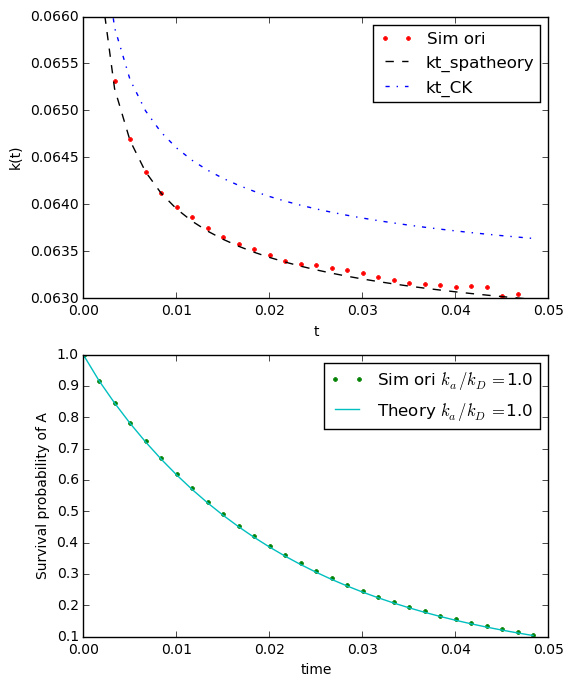

In [257]:
dat = np.loadtxt('kfac1.0a1meanNar50k',delimiter=',')
plotk(dat,1.,rm,100,[0.063,0.066],'o')


kfactor=1.0
ka 0.125663706144 kd 0.125663706144 kon 0.0628318530718 keffSpatheory 0.0628318512206 kdd 0.125663698739
Spatheory CKtheory Sim 0.0642788456473 0.0642493782351 0.0642399226471
error btwn keffCK-Spatheory 2.9462950567e-06
error btwn CK-Spatheory 0.045864120487
error bwtn sim-Spatheory -0.0605533590648 for last600points
error bwtn sim-CK -0.0147170108433 for last600points


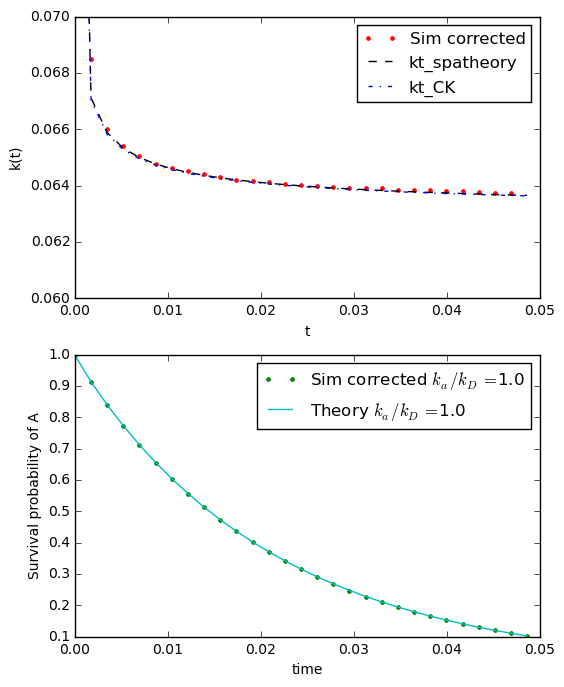

In [197]:
dat = np.loadtxt('kfacc1.0a1meanNar50k',delimiter=',')
#t1c,k1c,kt1c=plotk(dat,1.,f*rm,5,[0.06,0.07],'c')
t1,sts1,stt1=plotk(dat,1.,f*rm,100,[0.06,0.07],'c')

kfactor=10
ka 1.25663706144 kd 0.125663706144 kon 0.114239732858 keffSpatheory 0.112113824389 kdd 0.123096134937
Spatheory CKtheory Sim 0.116752995268 0.118958081085 0.116670798388
error btwn keffCK-Spatheory 1.86091862785
error btwn CK-Spatheory -1.8536662637
error bwtn sim-Spatheory -0.0704023735835 for last600points
error bwtn sim-CK -1.92276361224 for last600points


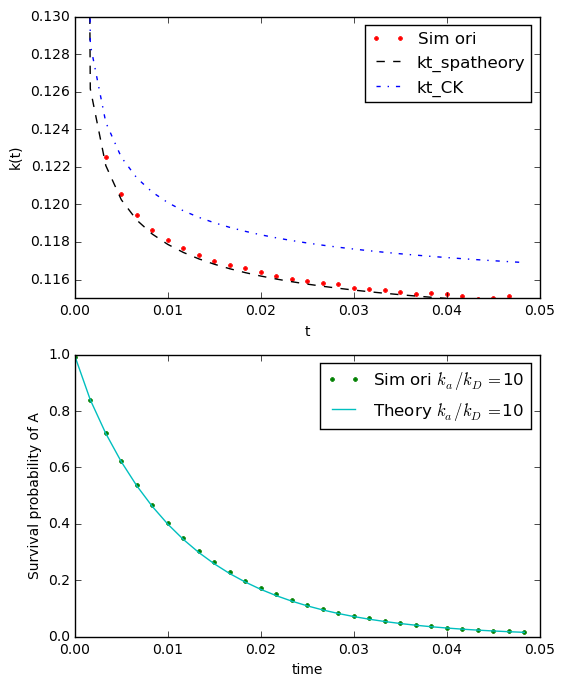

In [255]:
dat = np.loadtxt('kfac10.0a1meanNar50k',delimiter=',')
ks=plotk(dat,10,rm,100,[0.115,0.13],'o')


kfactor=10.0
ka 1.25663706144 kd 0.125663706144 kon 0.114239732858 keffSpatheory 0.114239726738 kdd 0.125663698739
Spatheory CKtheory Sim 0.119150330468 0.119050019641 0.119129632396
error btwn keffCK-Spatheory 5.35689996756e-06
error btwn CK-Spatheory 0.0842593963846
error bwtn sim-Spatheory -0.0173713935591 for last600points
error bwtn sim-CK 0.0668733657941 for last600points


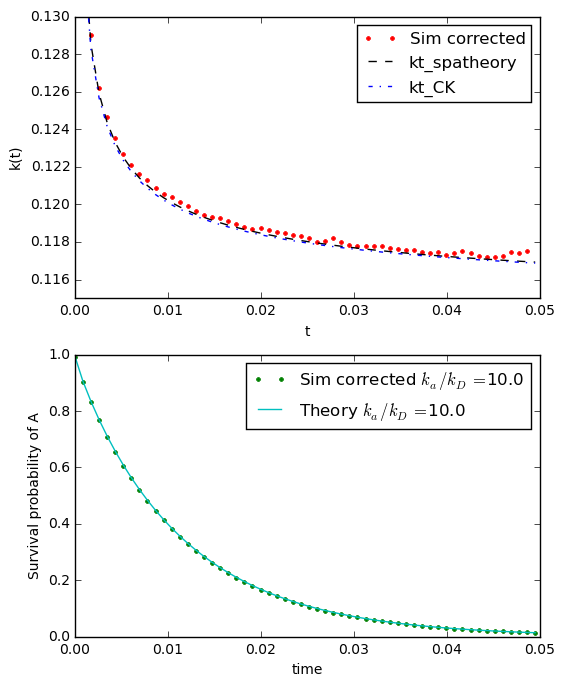

In [254]:
dat = np.loadtxt('kfacc10.0a1meanNar50k',delimiter=',')
plotk(dat,10.,f*rm,50,[0.115,0.13],'c')

kfactor=10.0
ka 1.25663706144 kd 0.125663706144 kon 0.114239732858 keffSpatheory 0.114239726738 kdd 0.125663698739
Spatheory CKtheory Sim 0.119150434357 0.119050121409 0.11910583562
error btwn keffCK-Spatheory 5.35689996756e-06
error btwn CK-Spatheory 0.0842611051249
error bwtn sim-Spatheory -0.0374306117431 for last600points
error bwtn sim-CK 0.0467989539347 for last600points


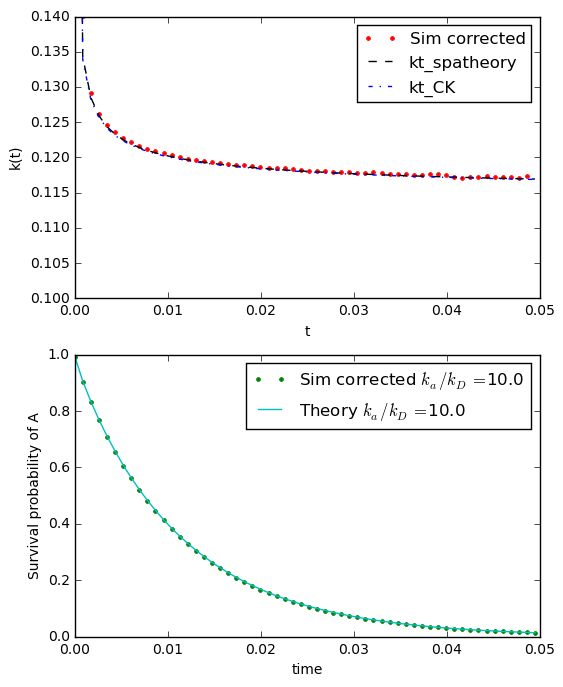

In [231]:
dat = np.loadtxt('kfacc10.0a01meanNar50k',delimiter=',')
plotk(dat,10.,f*rm,50,[0.1,0.14],'c')

kfactor=100
ka 12.5663706144 kd 0.125663706144 kon 0.124419511033 keffSpatheory 0.12190202184 kdd 0.123096134937
Spatheory CKtheory Sim 0.127521105437 0.130153478069 0.127491342563
error btwn keffCK-Spatheory 2.02338778872
error btwn CK-Spatheory -2.0225142431
error bwtn sim-Spatheory -0.0233395673276 for last600points
error bwtn sim-CK -2.04538176436 for last600points


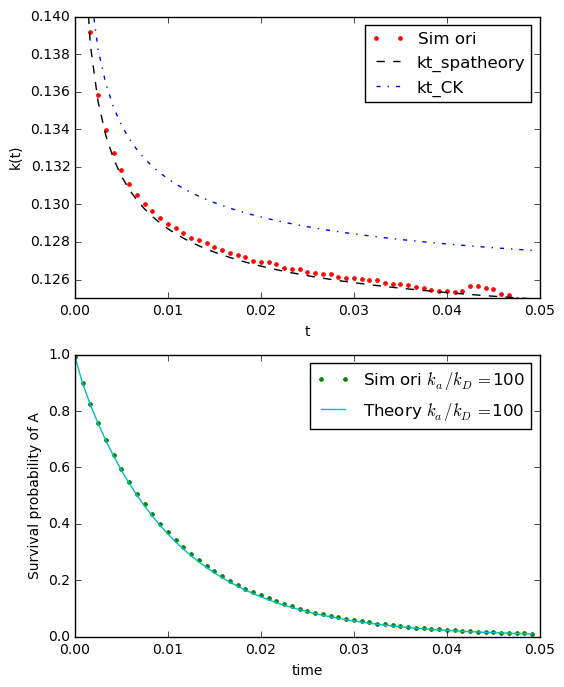

In [253]:
dat = np.loadtxt('kfac100.0a1meanNar50k',delimiter=',')
plotk(dat,100,rm,50,[0.125,0.14],'o')

kfactor=100
ka 12.5663706144 kd 0.125663706144 kon 0.124419511033 keffSpatheory 0.124419503774 kdd 0.125663698739
Spatheory CKtheory Sim 0.13024486547 0.130125849355 0.130225364795
error btwn keffCK-Spatheory 5.83424747708e-06
error btwn CK-Spatheory 0.0914623153152
error bwtn sim-Spatheory -0.0149723177806 for last600points
error bwtn sim-CK 0.0764763035062 for last600points
kfactor=100
ka 12.5663706144 kd 0.125663706144 kon 0.124419511033 keffSpatheory 0.124419503774 kdd 0.125663698739
Spatheory CKtheory Sim 0.130244890145 0.130125873526 0.130209414422
error btwn keffCK-Spatheory 5.83424747708e-06
error btwn CK-Spatheory 0.0914626857552
error bwtn sim-Spatheory -0.0272377080876 for last600points
error bwtn sim-CK 0.0642000653283 for last600points


(1.02, 1.1)

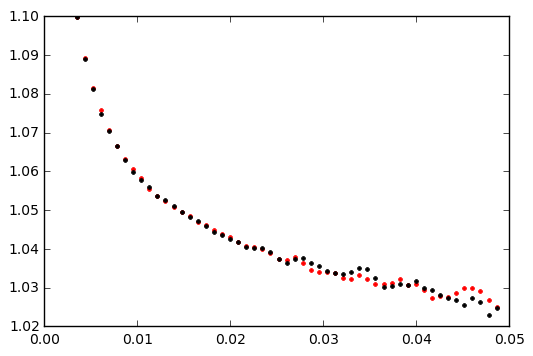

In [15]:
dat1 = np.loadtxt('data/kfacc100.0a1meanNar50k',delimiter=',')
dat2 = np.loadtxt('data/kfacc100.0a01meanNar30k',delimiter=',')
#plotk(dat,100,f*rm,50,[0.125,0.14],'c')
t100c1,k100c1,kt100c1=plotk(dat1,100,f*rm,50,[0.125,0.14],'c')
t100c2,k100c2,kt100c2=plotk(dat2,100,f*rm,50,[0.125,0.14],'c')
#plotk(dat,100,f*rm,50,[0.125,0.14],'c')
plt.close("all")
plt.plot(t100c1,k100c1,'r.')
plt.plot(t100c2,k100c2,'k.')
plt.ylim([1.02,1.1])

kfactor=0.1
ka 0.0125663706144 kd 0.125663706144 kon 0.0114239732858 keffSpatheory 0.0114023520834 kdd 0.123096134937
Spatheory CKtheory Sim 0.0114304651732 0.0114516164144 0.0114302965902
error btwn keffCK-Spatheory 0.189261667854
error btwn CK-Spatheory -0.184700922844
error bwtn sim-Spatheory -0.00147485692784 for last600points
error bwtn sim-CK -0.186173055697 for last600points


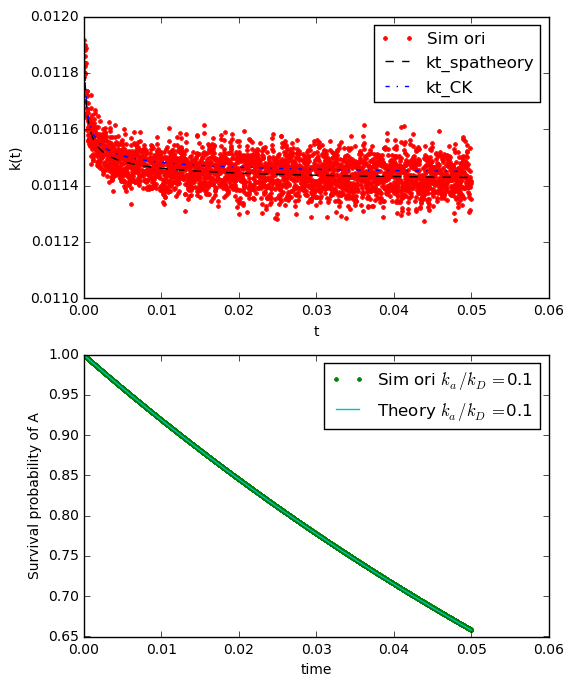

In [6]:
dat = np.loadtxt('kfac0.1a1meanNar50k',delimiter=',')
ks=plotk(dat,0.1,rm,1,[0.011,0.012],'o')


kfactor=0.1
ka 0.0125663706144 kd 0.125663706144 kon 0.0114239732858 keffSpatheory 0.0114239732246 kdd 0.125663698739
Spatheory CKtheory Sim 0.0114716423992 0.0114706785381 0.0114683414389
error btwn keffCK-Spatheory 5.35690057496e-07
error btwn CK-Spatheory 0.0084028253443
error bwtn sim-Spatheory -0.0287749576977 for last600points
error bwtn sim-CK -0.0203745502628 for last600points


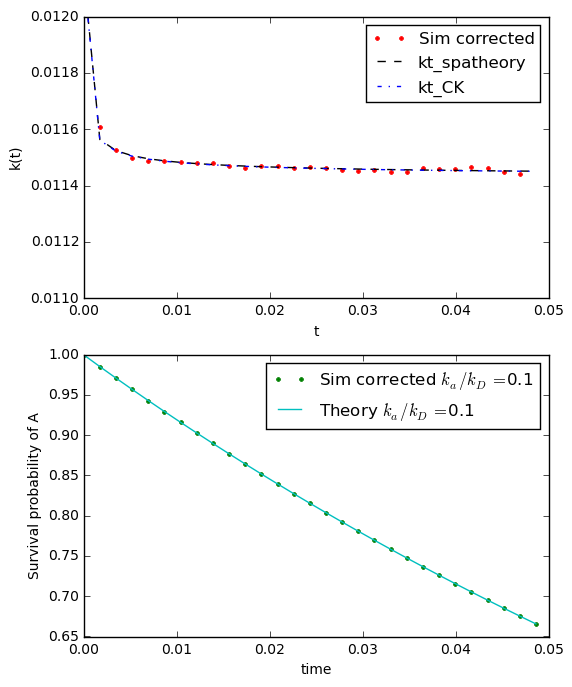

In [194]:
dat = np.loadtxt('kfacc0.1a1meanNar50k',delimiter=',')
#t01c,k01c,kt01c=plotk(dat,0.1,f*rm,5,[0.011,0.012],'c')
t01,sts01,stt01=plotk(dat,0.1,f*rm,100,[0.011,0.012],'c')

kfactor=0.01
ka 0.00125663706144 kd 0.125663706144 kon 0.00124419511033 keffSpatheory 0.00124393821541 kdd 0.123096134937
Spatheory CKtheory Sim 0.00124427275468 0.0012445229495 0.00124258840371
error btwn keffCK-Spatheory 0.0206474786635
error btwn CK-Spatheory -0.0201036723552
error bwtn sim-Spatheory -0.135368308203 for last600points
error bwtn sim-CK -0.155444766557 for last600points


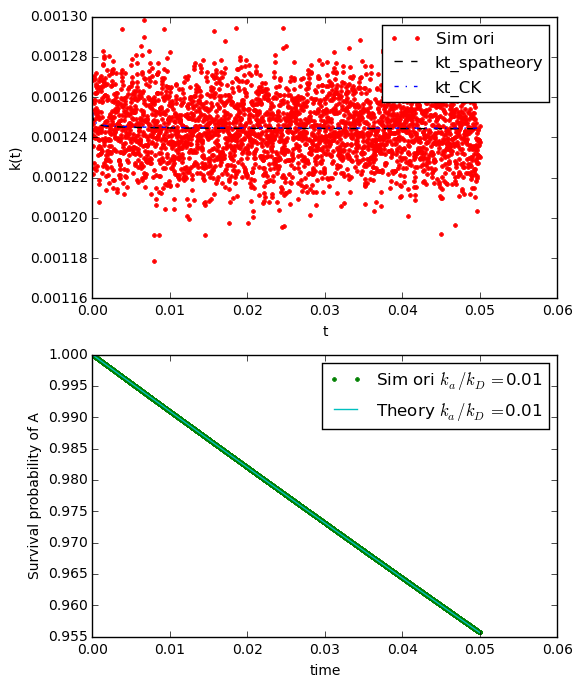

In [119]:
dat = np.loadtxt('kfac0.01a1meanNar50k',delimiter=',')
plotk(dat,0.01,rm,1,[],'o')

kfactor=0.01
ka 0.00125663706144 kd 0.125663706144 kon 0.00124419511033 keffSpatheory 0.00124419510961 kdd 0.125663698739
Spatheory CKtheory Sim 0.00124453065225 0.00124452381124 0.00124524723508
error btwn keffCK-Spatheory 5.83424709784e-08
error btwn CK-Spatheory 0.000549689321911
error bwtn sim-Spatheory 0.0575785596488 for last600points
error bwtn sim-CK 0.0581285654739 for last600points


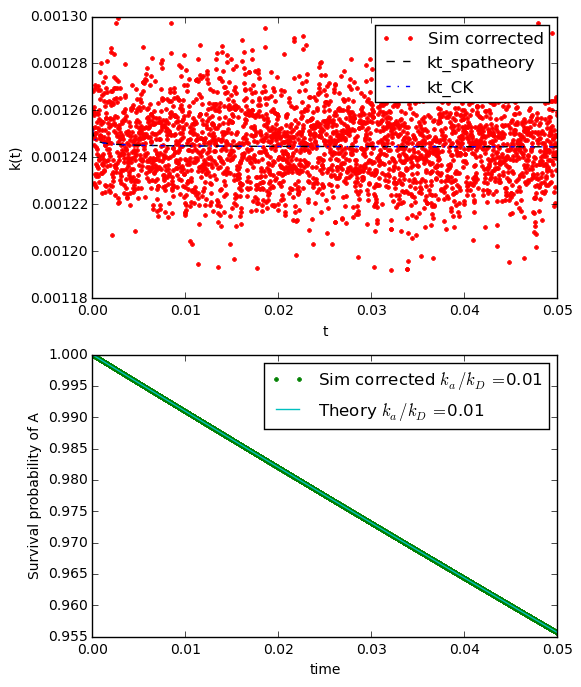

In [128]:
dat = np.loadtxt('kfacc0.01a1meanNar50k',delimiter=',')
plotk(dat,0.01,f*rm,1,[],'c')

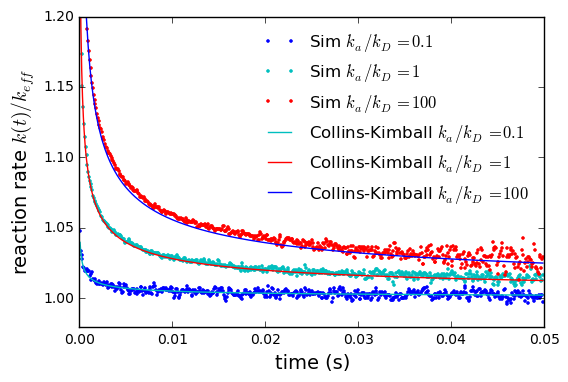

In [261]:
sz=4
plt.plot(t01c,k01c,'b.',markersize=sz,label='Sim $k_a/k_D=0.1$')
plt.plot(t1c,k1c,'c.',markersize=sz,label='Sim $k_a/k_D=1$')
plt.plot(t100c,k100c,'r.',markersize=sz,label='Sim $k_a/k_D=100$')

plt.plot(t01c,kt01c[1:-1],'c',label='Collins-Kimball $k_a/k_D=0.1$')
plt.plot(t1c,kt1c[1:-1],'r-',label='Collins-Kimball $k_a/k_D=1$')
plt.plot(t100c,kt100c[1:-1],'b',label='Collins-Kimball $k_a/k_D=100$')

plt.legend(loc='best',fontsize=12,frameon=False)
plt.ylim([0.98,1.2])
plt.ylabel('reaction rate $k(t)/k_{eff}$',fontsize=14)
plt.xlabel('time (s)',fontsize=14)
#plt.xscale('log')
#plt.yscale('log')
#plt.savefig("figure/kt.png",format='png',dpi=300)    

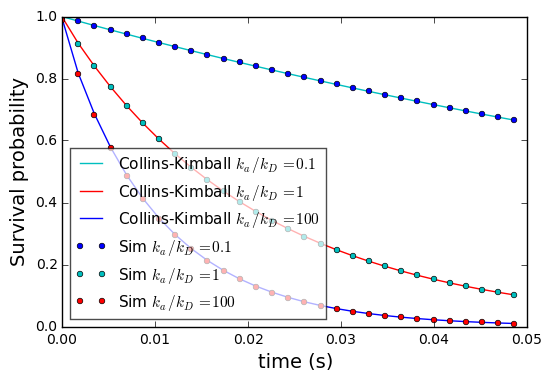

In [201]:
sz=4
plt.plot(t01,stt01,'c',label='Collins-Kimball $k_a/k_D=0.1$')
plt.plot(t1,stt1,'r-',label='Collins-Kimball $k_a/k_D=1$')
plt.plot(t100,stt100,'b',label='Collins-Kimball $k_a/k_D=100$')

plt.plot(t01,sts01,'bo',markersize=sz,label='Sim $k_a/k_D=0.1$')
plt.plot(t1,sts1,'co',markersize=sz,label='Sim $k_a/k_D=1$')
plt.plot(t100,sts100,'ro',markersize=sz,label='Sim $k_a/k_D=100$')

plt.legend(loc='lower left',fontsize=11,framealpha=0.7)
#plt.ylim([0,0.9])
plt.ylabel('Survival probability',fontsize=14)
plt.xlabel('time (s)',fontsize=14)
plt.savefig("figure/st.png",format='png',dpi=300)    